# **Brain Tumor Image Classification**

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import umap
import torch
import shutil
import time
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from re import IGNORECASE
from inspect import isgenerator
from itertools import product
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from copy import deepcopy
from google.colab import files
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Load Data

In [ ]:
# Path to zip
zip_path = "/content/archive.zip"  # Update with your zip file path
extract_path = "/content/tumor_images"

# Extract all files from the zip archive to the extract_path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define image paths and labels
image_paths = []
labels = []
for folder in ['1', '2', '3']:
    folder_path = os.path.join(extract_path, folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".png"):
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(int(folder))

# Load and flatten RGB images
image_data_rgb = []
for path in image_paths:
    img = Image.open(path).resize((64, 64))
    img_array = np.array(img)
    image_data_rgb.append(img_array.flatten())

image_data_rgb = np.array(image_data_rgb)
print("RGB Image data shape:", image_data_rgb.shape)

# Save a copy (optional)
image_data_copy = image_data_rgb.copy()

RGB Image data shape: (3064, 16384)


## PCA

In [ ]:
pca = PCA(n_components=0.95)
data_reduced = pca.fit_transform(image_data_copy)
print(pca.n_components_)
print(f'Perserved Variance: {round(np.sum(pca.explained_variance_ratio_),4)}')
print(data_reduced.shape)

589
Perserved Variance: 0.9501
(3064, 589)


In order to preserve 95% variance we need **589 principal components**. A reduction of 15795 principal components.

## Plot 10 Images of Reconstruction

In [ ]:
pca_90 = PCA(n_components=0.90)
data_reduced_90 = pca_90.fit_transform(image_data_copy)
reconstructed_images = pca_90.inverse_transform(data_reduced_90)

print(pca_90.n_components_)

309


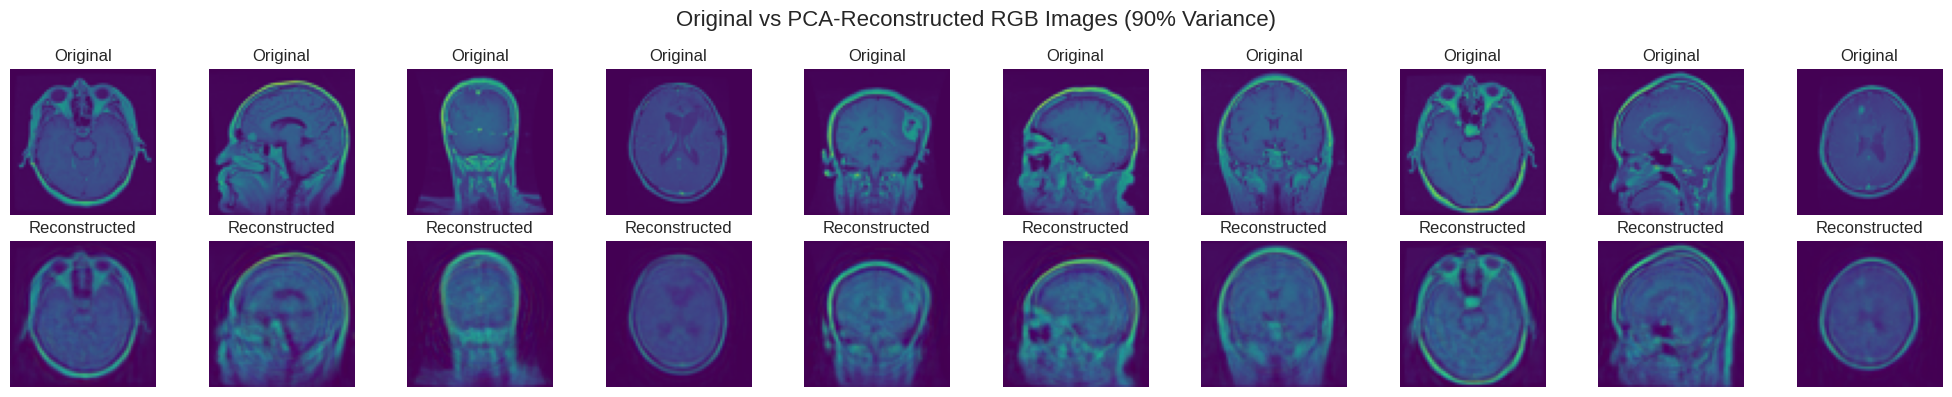

In [ ]:
indices = list(range(len(image_data_rgb)))
random.shuffle(indices)
indices = indices[:10]

plt.figure(figsize=(20, 4))

for i, idx in enumerate(indices):
    # Original
    plt.subplot(2, 10, i + 1)
    original = image_data_rgb[idx].reshape(64, 64, 4)[:, :, :3].astype(np.uint8)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, 10, i + 11)
    reconstructed = np.clip(reconstructed_images[idx], 0, 255).reshape(64, 64, 4)[:, :, :3].astype(np.uint8)
    plt.imshow(reconstructed)
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs PCA-Reconstructed RGB Images (90% Variance)", fontsize=16)
plt.tight_layout()
plt.show()

## **Use Visuals to Identify Clusters**


### Reduce to 2 dimensions

In [ ]:
pca = PCA(n_components=2)
data_reduced_2 = pca.fit_transform(image_data_copy)

print(pca.n_components_)
print(f'Perserved Variance: {round(np.sum(pca.explained_variance_ratio_),4)}')
print(data_reduced_2.shape)

2
Perserved Variance: 0.2956
(3064, 2)


### 2D Scatter Plot

In [ ]:
label_colors = {1: 'red', 2: 'orange', 3: 'green'}
label_names = {
    1: 'meningioma (1)',
    2: 'glioma (2)',
    3: 'pituitary tumor (3)'
}


def plot_scatter(reduced_data, labels, images, name):
    plt.figure(figsize=(13, 10))

    for lab in np.unique(labels):
        indices = np.where(labels == lab)
        plt.scatter(
            reduced_data[indices, 0],
            reduced_data[indices, 1],
            label=label_names[lab],
            color=label_colors[lab],
            s=40,
            edgecolors='black',
            linewidth=0.5,
            alpha=0.6
        )

    sampled_indices = random.sample(range(len(labels)), 30)
    for i in sampled_indices:
        image = images[i].reshape(64, 64, 4)[:, :, :3].astype(np.uint8)
        imagebox = OffsetImage(image, zoom=0.4)
        ab = AnnotationBbox(imagebox, (reduced_data[i, 0], reduced_data[i, 1]), frameon=False)
        plt.gca().add_artist(ab)

    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.title(f"{name} of Tumor Images", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

PCA Plot

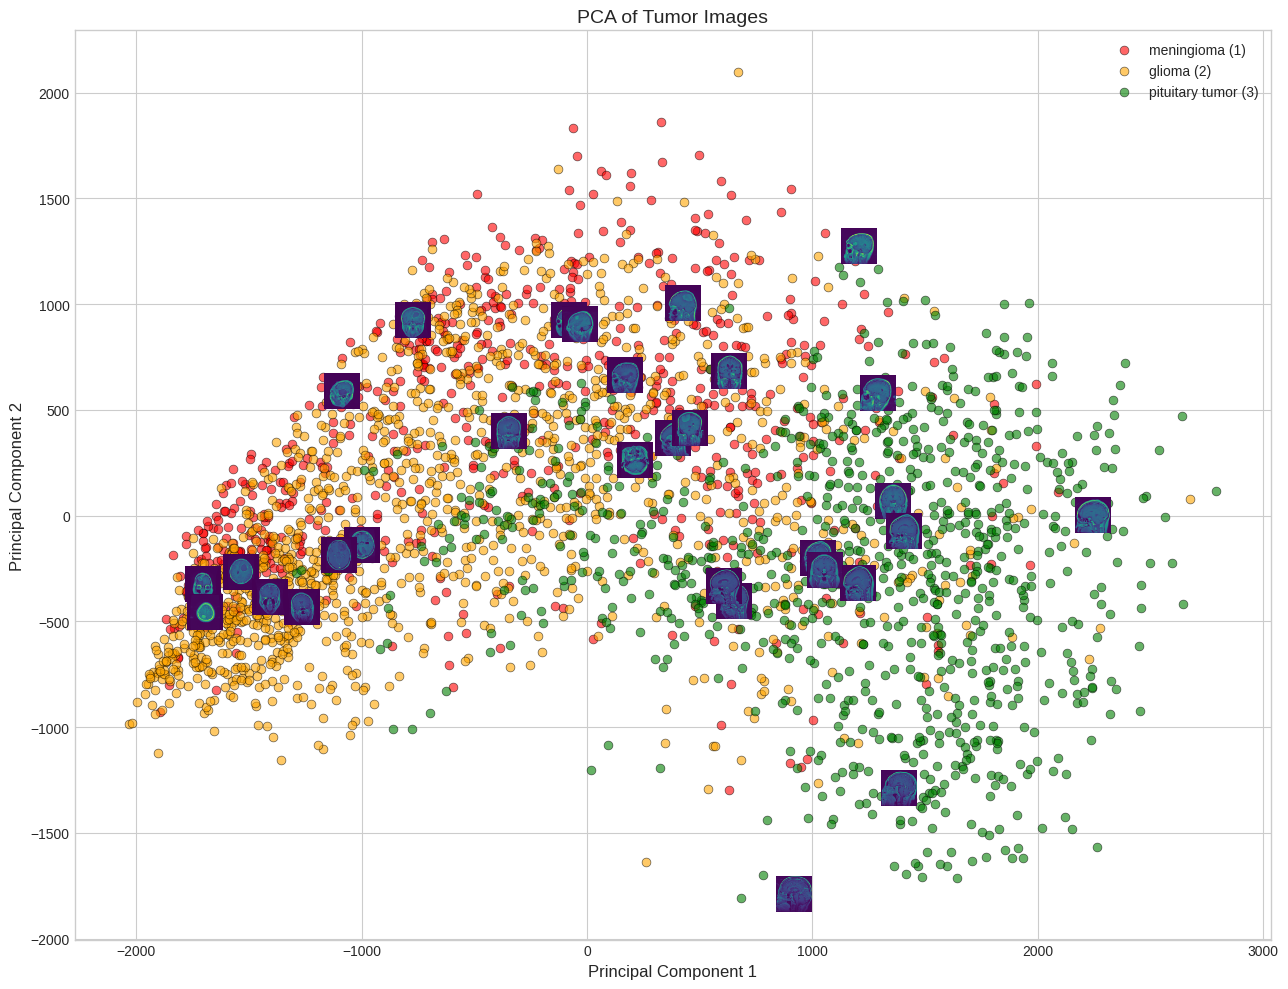

In [ ]:
plot_scatter(data_reduced_2, labels, image_data_rgb, "PCA")

t-SNE Plot

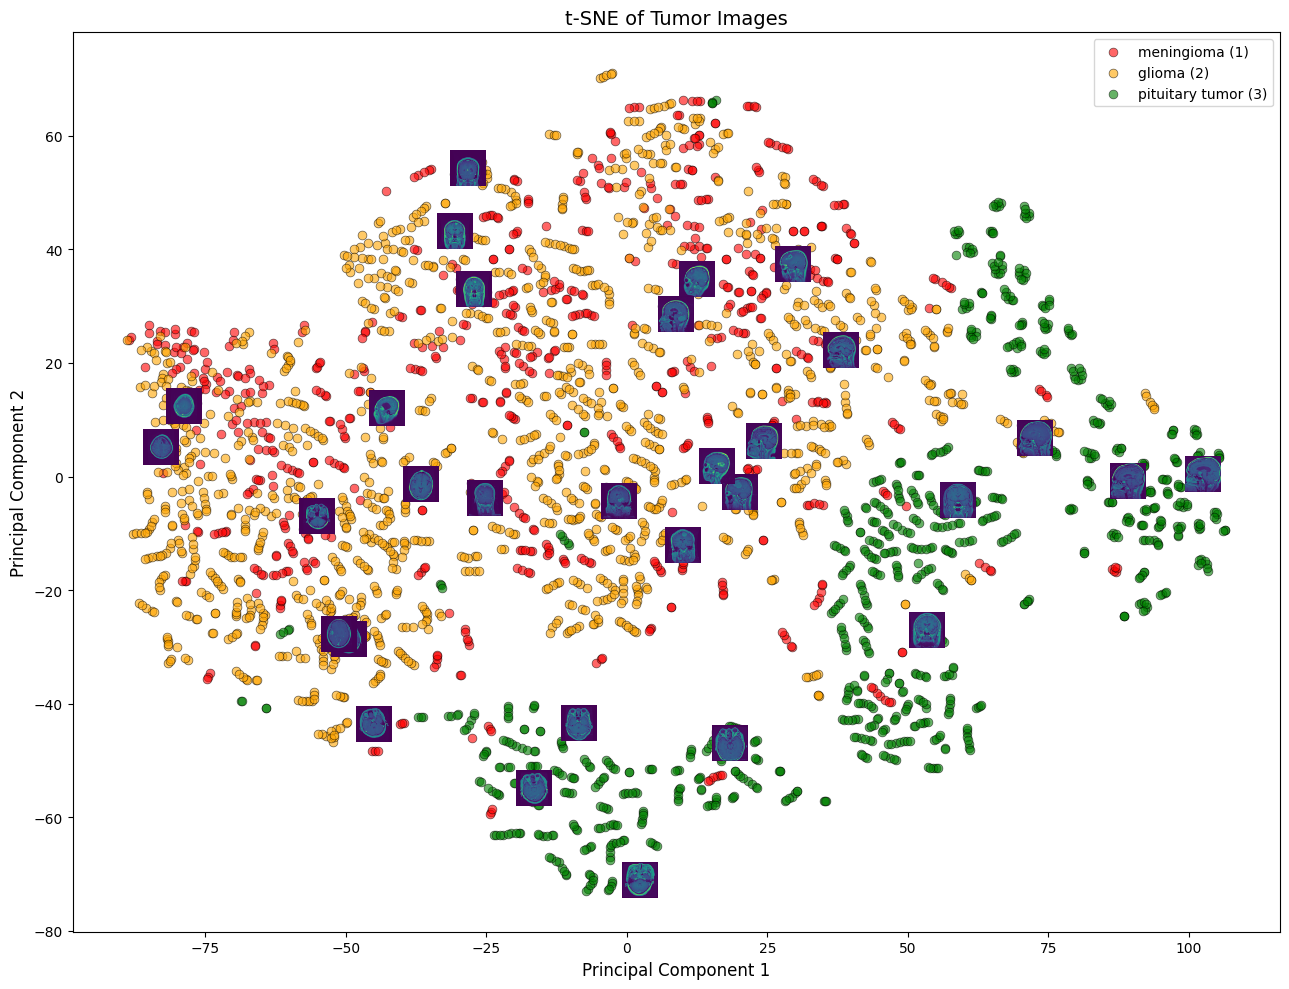

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
data_tsne = tsne.fit_transform(image_data_copy)
plot_scatter(data_tsne, labels, image_data_copy, "t-SNE")

LLE Plot

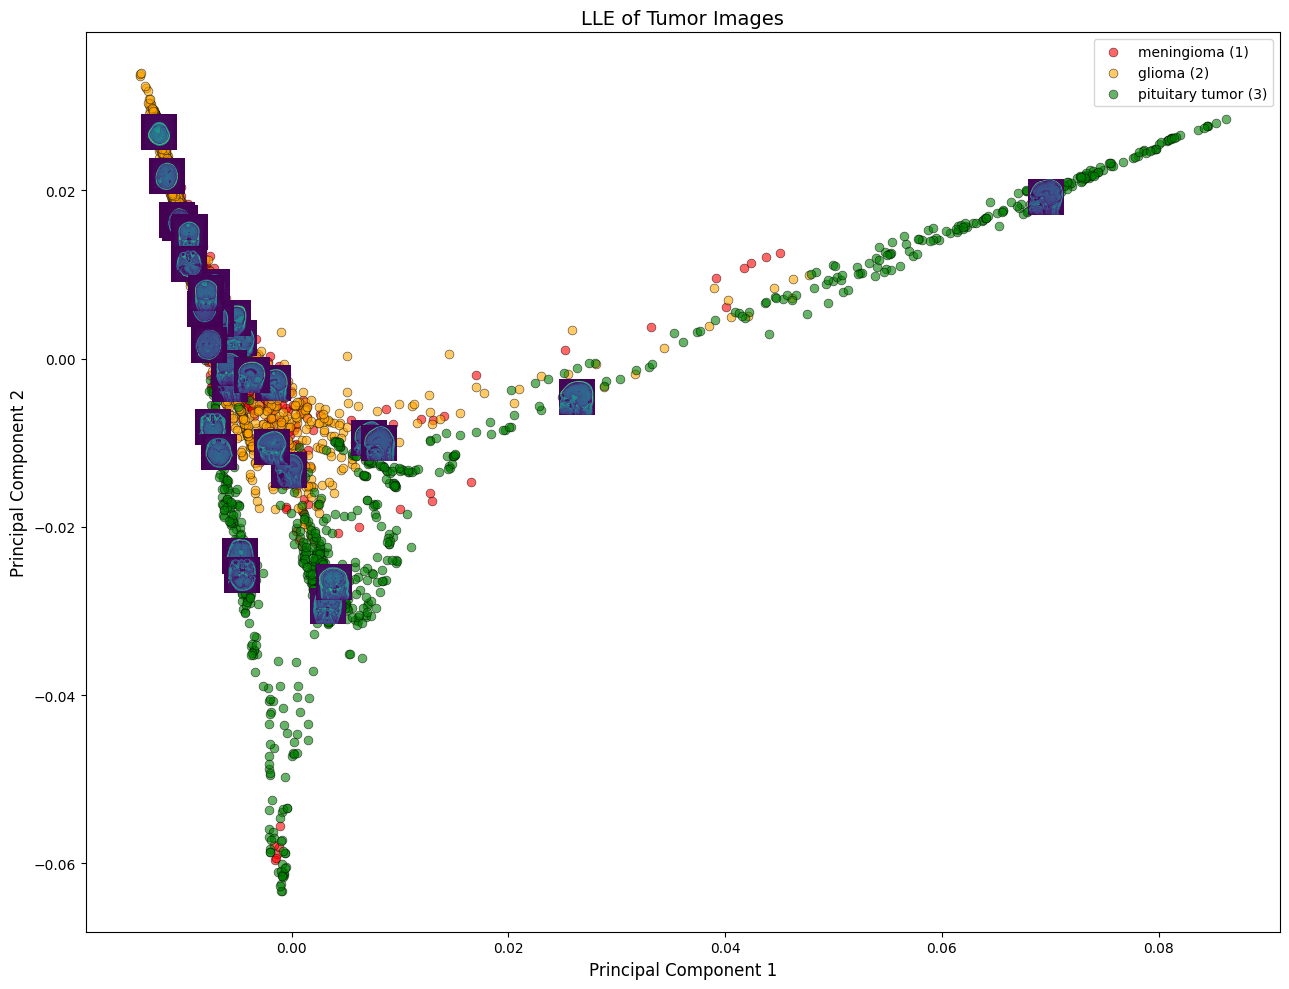

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=20, method='standard', random_state=42)
data_lle = lle.fit_transform(image_data_copy)
plot_scatter(data_lle, labels, image_data_copy, "LLE")

UMAP Plot

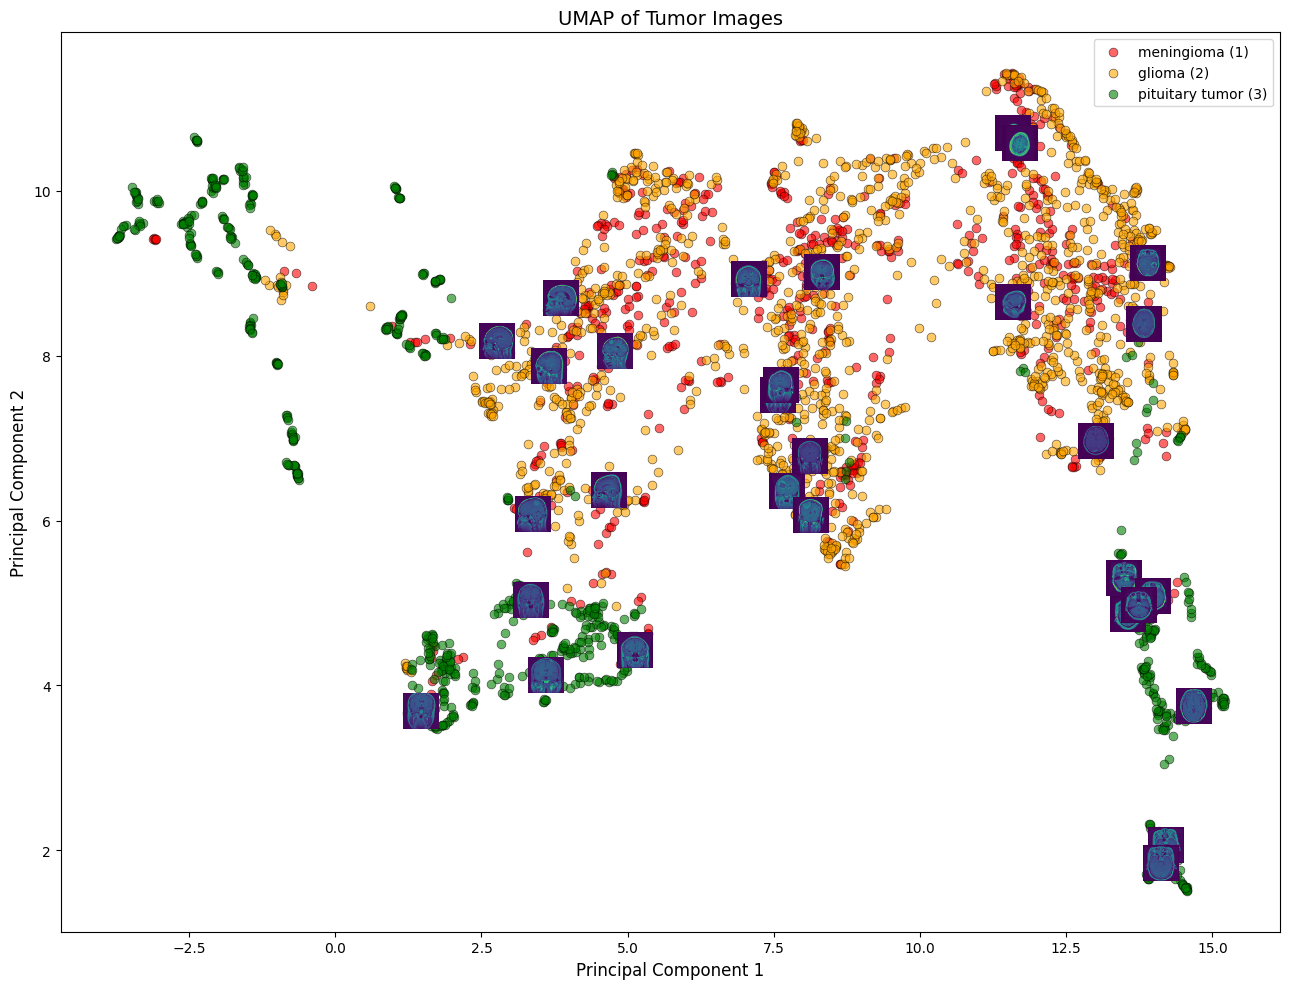

In [ ]:
umap_model = umap.UMAP(n_components=2, random_state=42)
data_umap = umap_model.fit_transform(image_data_copy)
plot_scatter(data_umap, labels, image_data_copy, "UMAP")

### Summary

The t-SNE plot shows clear seperation between the tumor types, compared to the other plots. UMap did decent if defining clusters, but they are very spread out. PCA has a lot of overlap, so does LLE.

## K-Means

### Silhouette Score

In [ ]:
# data_reduced is PCA with 95% variance kept
K = [KMeans(n_clusters=k, random_state=42).fit(data_reduced) for k in range(1, 10)]
sil_scores = [silhouette_score(data_reduced, model.labels_) for model in K[1:]]

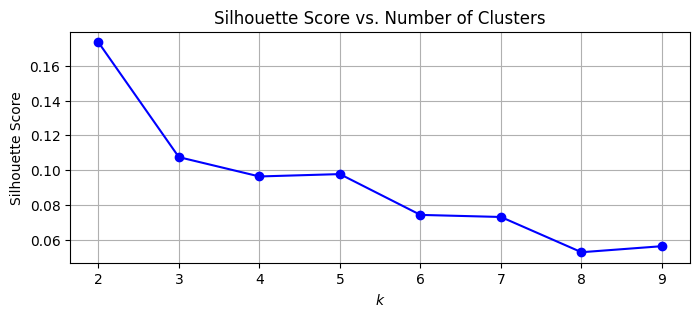

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), sil_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid()
plt.show()

Using Silhouette Score we see the the most optimal number of clusters is 2. Which makes sense beacuse if we look back at our PCA plot from before tumor 3 was seperated well, while tumors 1 & 2 heavily overlapped. Since we are classifiying 3 types of tumors we would hope the Silhouette Score would be highest for 3 clusters.

### Clusters accuracy and matrix

In [ ]:
label_colors = {1: 'red', 2: 'orange', 3: 'green'}
label_names = {
    1: 'meningioma (1)',
    2: 'glioma (2)',
    3: 'pituitary tumor (3)'
}

y = np.array(labels)

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(data_reduced)

In [ ]:
def match_labels(true_labels, cluster_labels):
    confusion = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-confusion)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned_preds = np.array([mapping[cl] for cl in cluster_labels])
    return aligned_preds

aligned_preds = match_labels(y, cluster_labels)
acc = accuracy_score(y, aligned_preds)
print(f"Clustering Accuracy: {acc:.4f}")

cm = confusion_matrix(y, aligned_preds)
print("Confusion Matrix:\n", cm)

Clustering Accuracy: 0.5783
Confusion Matrix:
 [[382 225 101]
 [592 669 165]
 [193  16 721]]


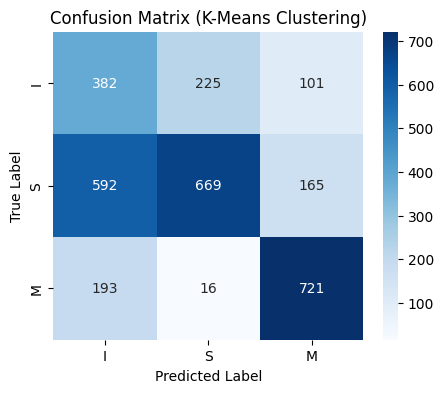

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["I", "S", "M"], yticklabels=["I", "S", "M"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (K-Means Clustering)")
plt.show()

### Visualize

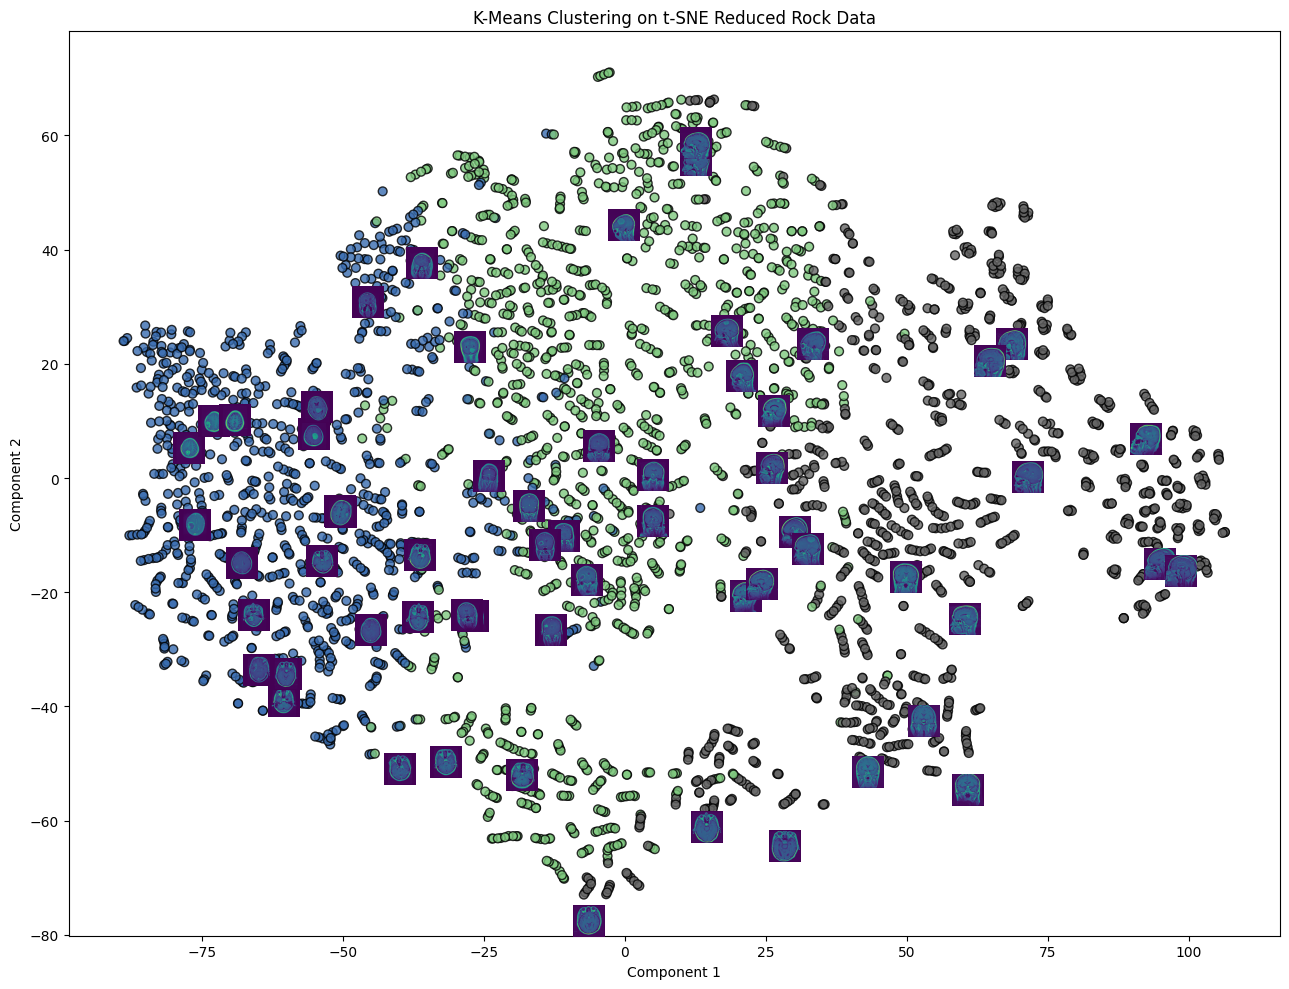

In [ ]:
# Our best plot was tsne
X = data_tsne

plt.figure(figsize=(13, 10))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='Accent', s=40, edgecolors='k', alpha=0.8)
plt.title("K-Means Clustering on t-SNE Reduced Rock Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

sampled_indices = np.random.choice(len(X), size=60, replace=False)

for i in sampled_indices:
    img = image_data_rgb[i].reshape(64, 64, 4)
    img = img[:, :, :3]
    imagebox = OffsetImage(img, zoom=0.35)
    ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                        xybox=(0, -20), boxcoords="offset points",
                        box_alignment=(0.5, 1), frameon=False)
    plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()

## EM

### BIC & AIC

In [ ]:
# data_reduced is PCA with 95% variance kept
gm = [GaussianMixture(n_components=k, random_state=42).fit(data_reduced) for k in range(1, 15)]
bics = [model.bic(data_reduced) for model in gm]
aics = [model.aic(data_reduced) for model in gm]
ks = range(1, 15)

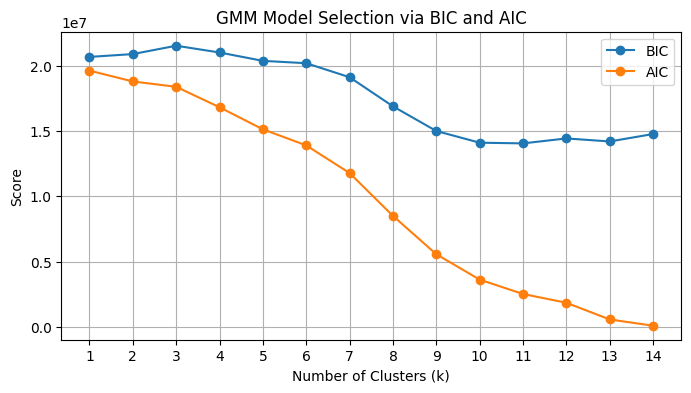

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ks, bics, label='BIC', marker='o')
plt.plot(ks, aics, label='AIC', marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("GMM Model Selection via BIC and AIC")
plt.xticks(ks)
plt.legend()
plt.grid()
plt.show()

Although BIC reaches its minimum around k = 8, we set k = 3 because we are clustering 3 differnet types of clusters

### Accuracy & Matrix

In [ ]:
gm = GaussianMixture(n_components=3, random_state=42).fit(data_reduced)
gm_labels = gm.fit_predict(data_reduced)

aligned_preds = match_labels(y, gm_labels)

acc = accuracy_score(y, aligned_preds)
print(f"Clustering Accuracy (GMM): {acc:.4f}")

cm = confusion_matrix(y, aligned_preds)
print("Confusion Matrix:\n", cm)

Clustering Accuracy (GMM): 0.5787
Confusion Matrix:
 [[382 226 100]
 [591 670 165]
 [193  16 721]]


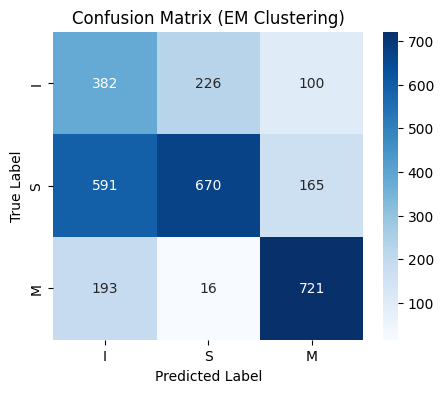

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["I", "S", "M"], yticklabels=["I", "S", "M"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (EM Clustering)")
plt.show()

### Plot

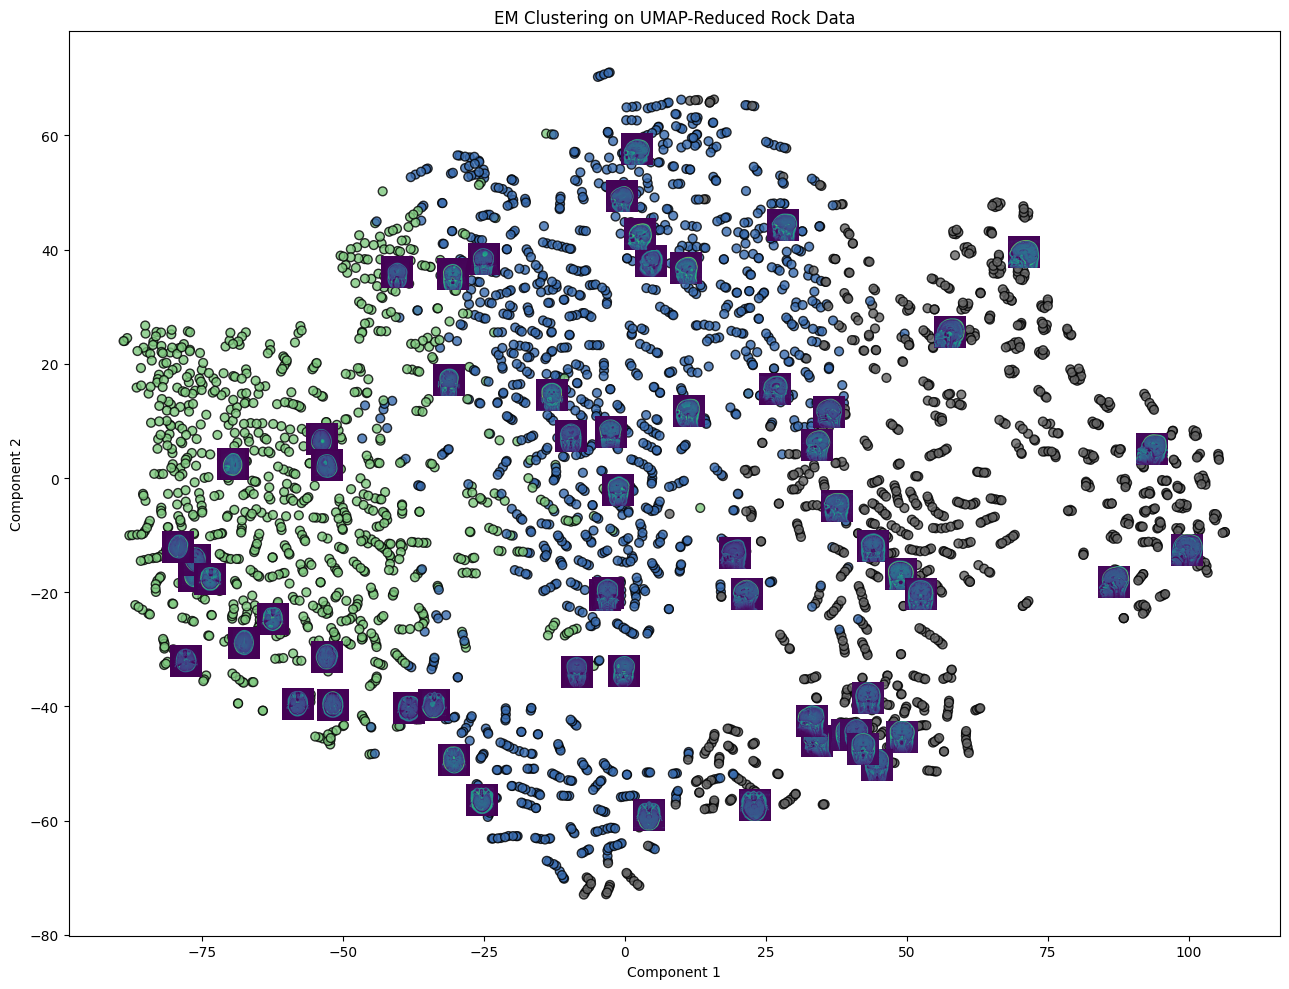

In [ ]:
# Our best plot was tsne
X = data_tsne
em_labels = gm.predict(data_reduced)

plt.figure(figsize=(13, 10))
plt.scatter(X[:, 0], X[:, 1], c=em_labels, cmap='Accent', s=40, edgecolors='k', alpha=0.8)
plt.title("EM Clustering on UMAP-Reduced Rock Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

sampled_indices = np.random.choice(len(X), size=60, replace=False)

for i in sampled_indices:
    img = image_data_rgb[i].reshape(64, 64, 4)
    img = img[:, :, :3]
    imagebox = OffsetImage(img, zoom=0.35)
    ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                        xybox=(0, -20), boxcoords="offset points",
                        box_alignment=(0.5, 1), frameon=False)
    plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()

### Generate 20 New Images

In [ ]:
pca_95 = PCA(n_components=0.95)
data_reduced_95 = pca_95.fit_transform(image_data_copy)

X_new, y_new = gm.sample(20)
X_recovered = pca_95.inverse_transform(X_new)
X_images = X_recovered.reshape(-1, 64, 64, 4)[:, :, :, :3]

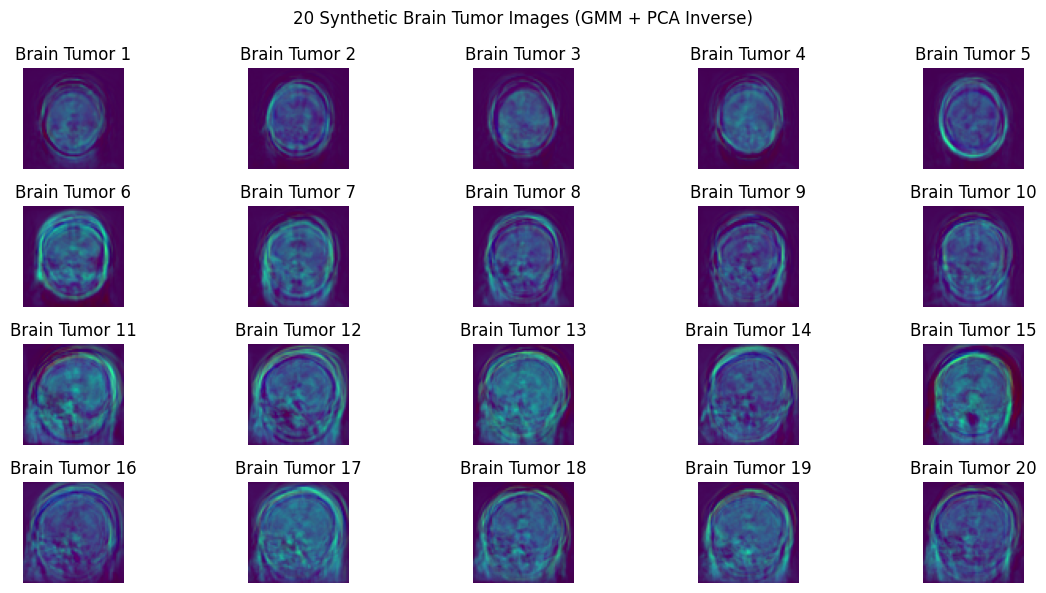

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.clip(X_images[i] / 255, 0, 1))
    plt.axis("off")
    plt.title(f"Brain Tumor {i+1}")
plt.suptitle("20 Synthetic Brain Tumor Images (GMM + PCA Inverse)")
plt.tight_layout()
plt.show()

## Build Neural Network

Split the data

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/archive',
    validation_split=0.25,
    subset='training',
    seed=42,
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/archive',
    validation_split=0.25,
    subset='validation',
    seed=42,
    image_size=(64, 64),
    batch_size=32,
    label_mode='categorical'
)


Found 3064 files belonging to 3 classes.
Using 2298 files for training.
Found 3064 files belonging to 3 classes.
Using 766 files for validation.


In [ ]:
model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Rescaling(1.0 / 255),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3,   activation='softmax')
])

sgd_opt = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
)

model.compile(
    optimizer=sgd_opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,059 (8.08 MB)

 Trainable params: 2,117,059 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

### Training Time

In [ ]:
start = time.time()
history = model.fit(train_ds, validation_data=val_ds, epochs=20)
print("Training time:", time.time() - start)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.5131 - loss: 0.9845 - val_accuracy: 0.7415 - val_loss: 0.5620
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.6947 - loss: 0.6794 - val_accuracy: 0.7937 - val_loss: 0.5375
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 280ms/step - accuracy: 0.7608 - loss: 0.5489 - val_accuracy: 0.8225 - val_loss: 0.4552
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.7947 - loss: 0.4817 - val_accuracy: 0.7859 - val_loss: 0.4710
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.7859 - loss: 0.4868 - val_accuracy: 0.8551 - val_loss: 0.3787
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 329ms/step - accuracy: 0.8607 - loss: 0.3509 - val_accuracy: 0.8708 - val_loss: 0.3221
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 274ms/step - accuracy: 0.8846 - loss: 0.2906 - val_accuracy: 0.8773 - val_loss: 0.2847
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step - accuracy: 0.9123 - loss: 0.2306 - val_accu

### Training and Validation Accuracy

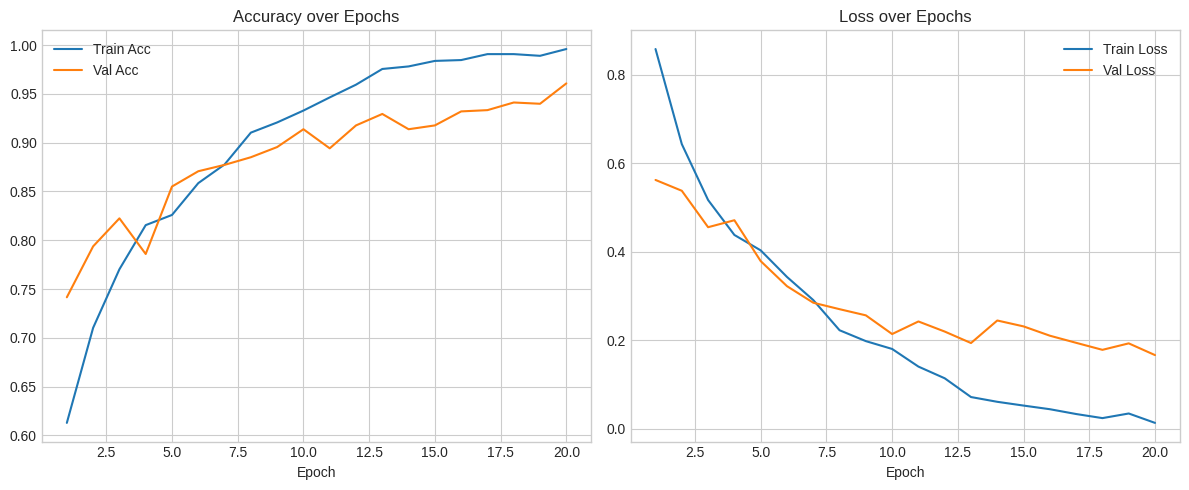

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,     label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss,     label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Parameters

In [ ]:
total_params = model.count_params()
bias_params  = sum(
    np.prod(var.shape)
    for var in model.trainable_variables
    if 'bias' in var.name
)

print(f"Total parameters: {total_params:,}")
print(f"Bias parameters: {bias_params:,}")

Total parameters: 2,117,059
Bias parameters: 227


### See how the model does during training

Found 3064 files belonging to 3 classes.
Using 2298 files for training.
Found 3064 files belonging to 3 classes.
Using 766 files for validation.


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,059 (8.08 MB)

 Trainable params: 2,117,059 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step

========== TRAINING: First Half ==========
Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 307ms/step - accuracy: 0.5352 - loss: 0.9541 - val_accuracy: 0.7311 - val_loss: 0.5842
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.7075 - loss: 0.6473 - val_accuracy: 0.7493 - val_loss: 0.5530
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.7775 - loss: 0.5220 - val_accuracy: 0.7911 - val_loss: 0.5119
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - accuracy: 0.8021 - loss: 0.4694 - val_accuracy: 0.7480 - val_loss: 0.5647
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 290ms/step - accuracy: 0.7910 - loss: 0.4832 - val_accuracy: 0.8381 - val_loss: 0.3887
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - accuracy: 0.8676 - loss: 0.3307 - val_accuracy: 0.8616 - val_loss: 0.3510
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 347ms/step - accuracy: 0.8753 - loss: 0.3152 - val_accuracy: 0.9008 - val_loss: 0.2504
Epoch 8/10
72/

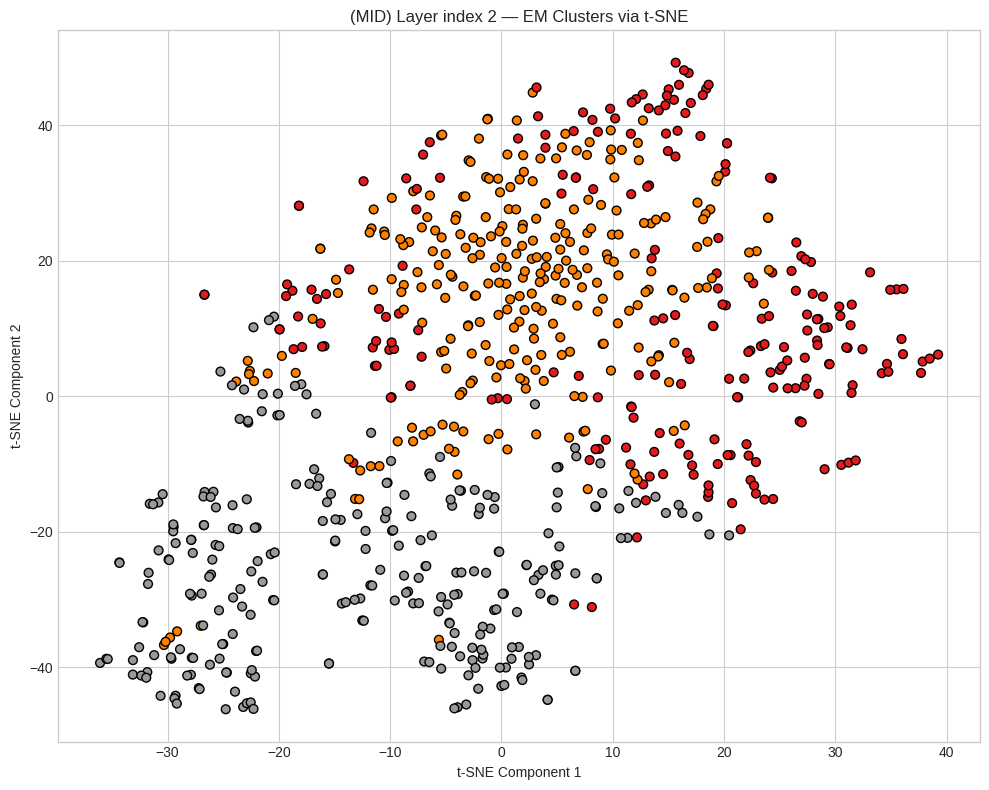


--- Clustering Neuron Activity from Layer index: 4 (MID) ---
Clustering Accuracy (MID): 0.6514
Confusion Matrix:
 [[ 64  73  34]
 [ 37 290  31]
 [  4  88 145]]


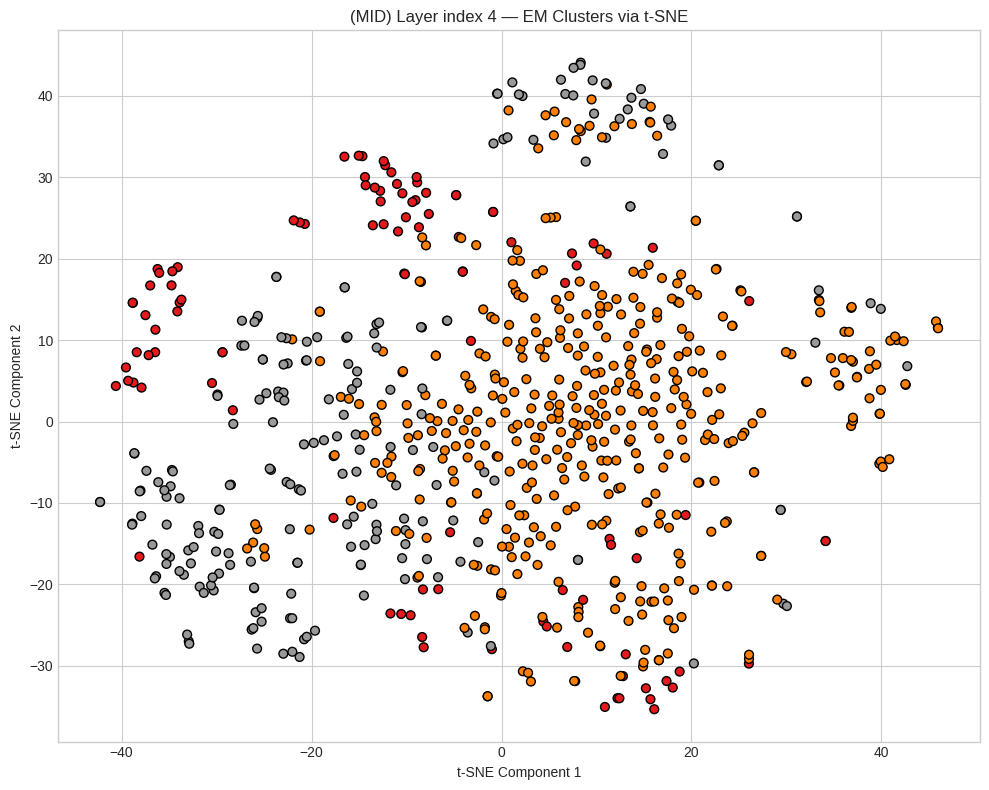


--- Clustering Neuron Activity from Layer index: 7 (MID) ---
Clustering Accuracy (MID): 0.8577
Confusion Matrix:
 [[121  36  14]
 [ 44 307   7]
 [  0   8 229]]


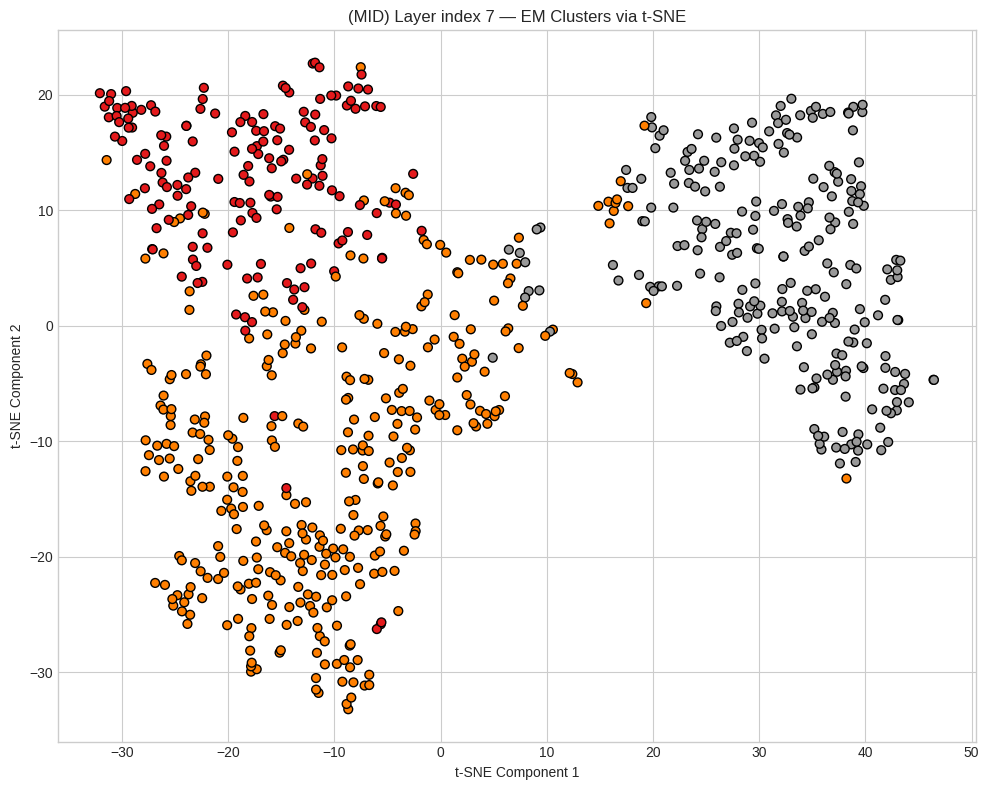


========== TRAINING: Second Half ==========
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - accuracy: 0.9499 - loss: 0.1381 - val_accuracy: 0.9034 - val_loss: 0.2311
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 367ms/step - accuracy: 0.9613 - loss: 0.1091 - val_accuracy: 0.9217 - val_loss: 0.2080
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 330ms/step - accuracy: 0.9792 - loss: 0.0675 - val_accuracy: 0.9217 - val_loss: 0.1981
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 352ms/step - accuracy: 0.9828 - loss: 0.0570 - val_accuracy: 0.8890 - val_loss: 0.2848
Epoch 15/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 335ms/step - accuracy: 0.9831 - loss: 0.0591 - val_accuracy: 0.9347 - val_loss: 0.2063
Epoch 16/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 37s 274ms/step - accuracy: 0.9924 - loss: 0.0308 - val_accuracy: 0.9360 - val_loss: 0.1963
Epoch 17/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 353ms/step - accuracy: 0.9924 - loss: 0.0234 - val_accuracy: 0.9452 - val_loss: 0.1843
Epoch 18/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 39s 32

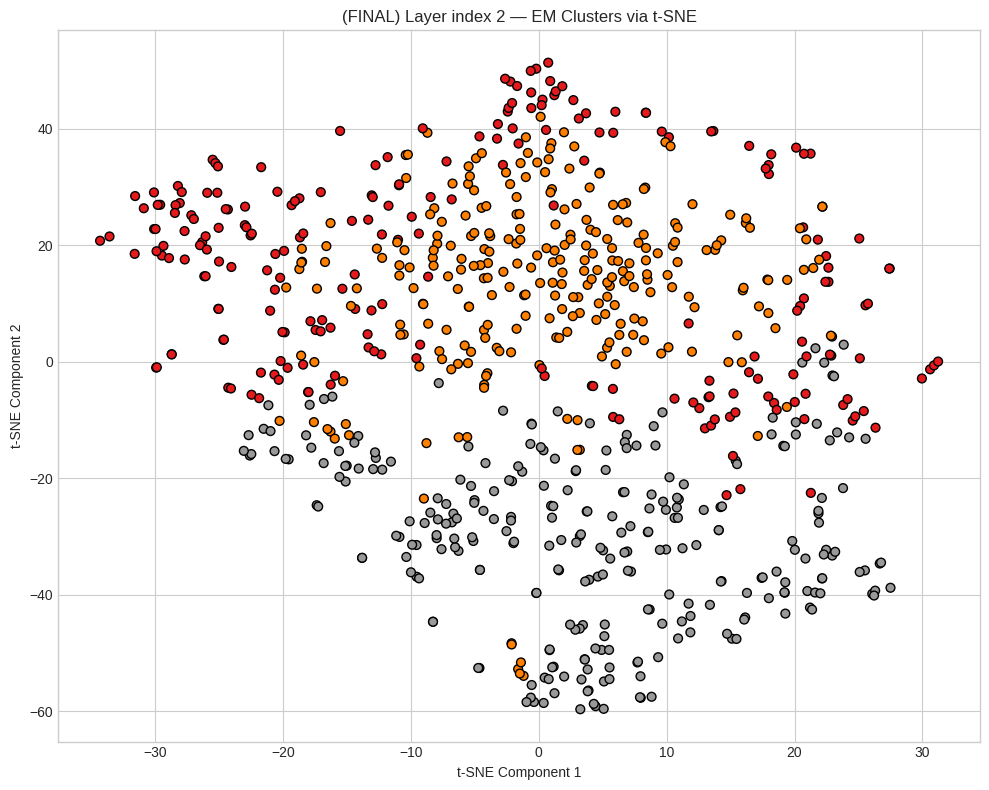


--- Clustering Neuron Activity from Layer index: 4 (FINAL) ---
Clustering Accuracy (FINAL): 0.6697
Confusion Matrix:
 [[ 66  70  35]
 [ 43 283  32]
 [  7  66 164]]


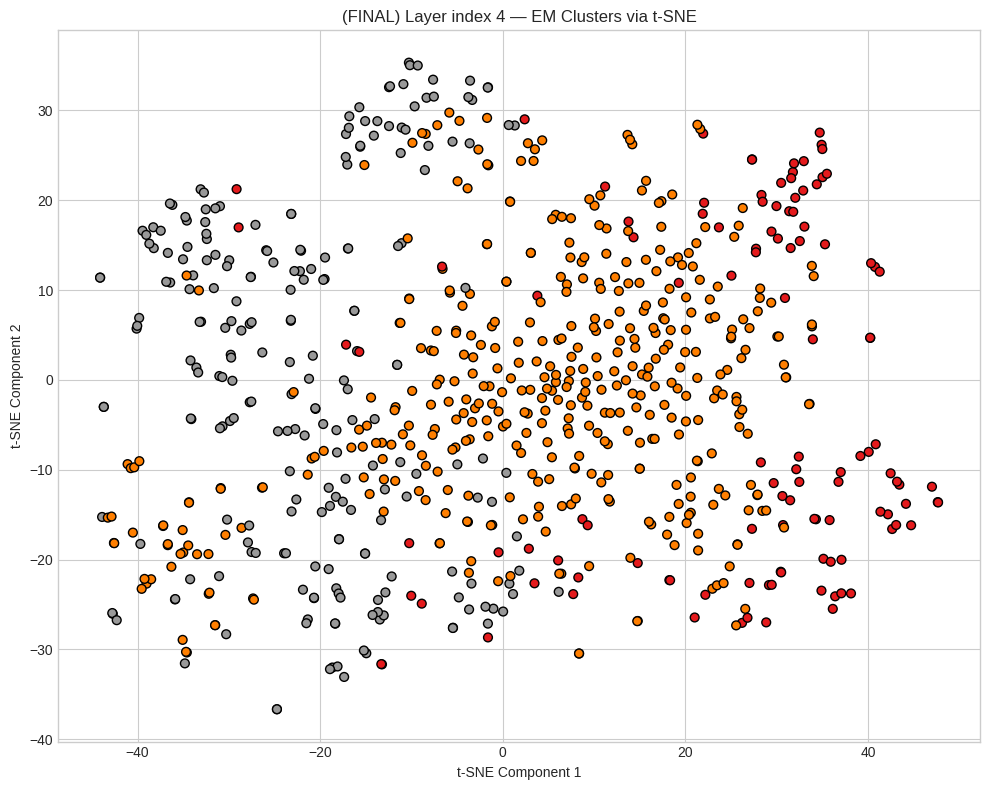


--- Clustering Neuron Activity from Layer index: 7 (FINAL) ---
Clustering Accuracy (FINAL): 0.8225
Confusion Matrix:
 [[124  21  26]
 [ 59 276  23]
 [  1   6 230]]


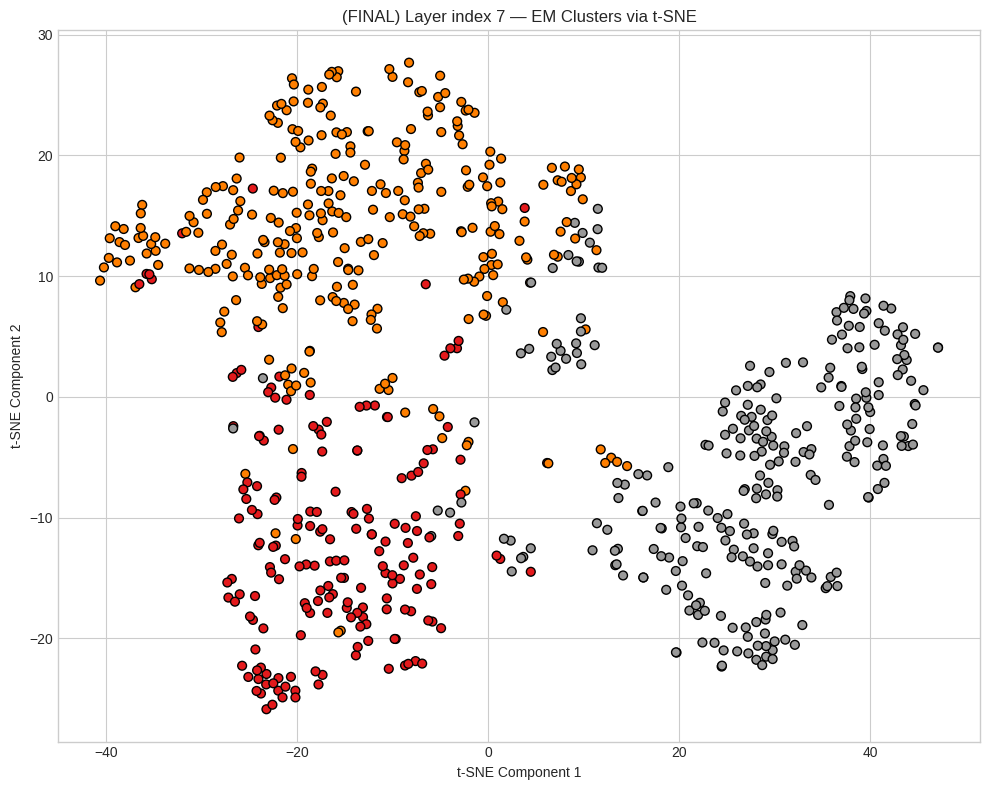

In [ ]:
# Define CNN using Functional API
inputs = tf.keras.Input(shape=(64, 64, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
sgd_opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_ = model.predict(val_ds.take(1))

def get_activations(model, layer_index, dataset):
    intermediate_layer_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[layer_index].output
    )
    activations = []
    labels = []
    for batch, label in dataset:
        act = intermediate_layer_model(batch, training=False)
        activations.append(tf.reshape(act, [act.shape[0], -1]).numpy())
        labels.append(label.numpy())
    return np.vstack(activations), np.argmax(np.vstack(labels), axis=1)

def match_labels(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-matrix)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    return np.array([mapping[p] for p in y_pred])

def cluster_and_visualize(model, val_ds, layer_indices, tag):
    for layer_index in layer_indices:
        print(f"\n--- Clustering Neuron Activity from Layer index: {layer_index} ({tag}) ---")
        activations, y_true = get_activations(model, layer_index, val_ds)
        pca = PCA(n_components=0.95, random_state=42)
        reduced = pca.fit_transform(activations)
        gm = GaussianMixture(n_components=3, random_state=42).fit(reduced)
        preds = gm.predict(reduced)
        aligned_preds = match_labels(y_true, preds)
        acc = accuracy_score(y_true, aligned_preds)
        cm = confusion_matrix(y_true, aligned_preds)
        print(f"Clustering Accuracy ({tag}): {acc:.4f}")
        print("Confusion Matrix:\n", cm)
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_data = tsne.fit_transform(reduced)
        plt.figure(figsize=(10, 8))
        plt.title(f"({tag}) Layer index {layer_index} — EM Clusters via t-SNE")
        plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=aligned_preds, cmap='Set1', s=40, edgecolors='k')
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.tight_layout()
        plt.show()

layers_to_use = [2, 4, 7]

# --- Train Halfway ---
print("\n========== TRAINING: First Half ==========")
history_1 = model.fit(train_ds, validation_data=val_ds, epochs=10)

# --- Analyze Midway ---
print("\n========== MID TRAINING ANALYSIS ==========")
cluster_and_visualize(model, val_ds, layers_to_use, tag="MID")

# --- Train Second Half ---
print("\n========== TRAINING: Second Half ==========")
history_2 = model.fit(train_ds, validation_data=val_ds, initial_epoch=10, epochs=20)

# --- Final Analysis ---
print("\n========== FINAL TRAINING ANALYSIS ==========")
cluster_and_visualize(model, val_ds, layers_to_use, tag="FINAL")


Clustering in the first layer showed no improvement over the course of training. In the middle clusters began to form, but still lacked clear and decisive seperation. The end layer showed string clustering with minimal misidentifications.